<a href="https://colab.research.google.com/github/threewisemonkeys-as/dl_fun/blob/master/speech/FSDD_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import random

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchaudio
import torchaudio.transforms as AT

import torchvision
from torchvision import utils
import torchvision.transforms as VT
import torchvision.transforms.functional as VTF

import torch.nn as nn
import torch.nn.functional as nnF

import matplotlib
import matplotlib.pyplot as plt

import librosa
import librosa.display as librosa_display

import numpy as np
import cv2

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython.core.debugger import set_trace
    from IPython import display
plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
class FSDD(Dataset):
    """Free Spoken Digit Dataset."""
    
    def __init__(self, root_dir, spec=False):
        """
        Args:
            root_dir (string): path of directory containing all wav files
        """
        self.root_dir = root_dir
        self.file_list = next(os.walk(self.root_dir))[2]
        self.spec=spec
        
    def __len__(self):
        self.file_list = next(os.walk(self.root_dir))[2]
        return len(self.file_list)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        file_path = os.path.join(self.root_dir, self.file_list[idx])
        label = torch.tensor(int(file_path.split('/')[-1].split('_')[0]), dtype=torch.long, device=device)

        #speaker = torch.tensor(file_path.split('/')[-1].split('_')[1], device=device)
        
        waveform, sample_rate = torchaudio.load(file_path)
        if self.spec:
            waveform = librosa.amplitude_to_db(np.abs(librosa.stft(waveform.squeeze(0).numpy(), n_fft=512)), ref=np.max)
            waveform = torch.tensor(cv2.resize(waveform, dsize=(256, 256), interpolation=cv2.INTER_CUBIC), device=device).unsqueeze(0)
        
        item = {'waveform': waveform, 'label': label}#, 'speaker': speaker}

        #waveform, sample_rate = librosa.load(file_path)
        #item = {'waveform': waveform, 'label': label}#, 'speaker': speaker}
        
        return item


In [0]:
digit_dataset = FSDD(root_dir='./data/recordings/')
plt.figure(figsize=(5,5))

for i in range(4):
    sample = digit_dataset[random.randrange(len(digit_dataset))]
    print("Shape of waveform: {}".format(sample['waveform'].size()))
    ax = plt.subplot(2, 2, i + 1)
    plt.tight_layout()
    ax.set_title(f"Label: {sample['label']}", color='g')
    plt.plot(sample['waveform'].t().numpy())

plt.show()

StopIteration: ignored

In [0]:
digit_dataset = FSDD(root_dir='./data/recordings/', spec=True)
dataloader = DataLoader(digit_dataset, batch_size=4, shuffle=True, num_workers=4)

for i_batch, batch in enumerate(dataloader):
    plt.imshow(batch['waveform'][0].squeeze(0).numpy())
    plt.suptitle(f"Label: {batch['label'][0]}", color='r')       
    break



In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1), # 1x256x256 --> 8x256x256
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 8x256x256 --> 8x128x128
            nn.Conv2d(8, 16, 3, padding=1), # 8x128x128 --> 16x128x128
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 16x128x128 --> 16x64x64
            nn.Conv2d(16, 32, 3, padding=1), # 16x64x64 --> 32x64x64
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32x64x64 --> 32x32x32
            nn.Conv2d(32, 64, 3, padding=1), # 32x32x32 --> 64x32x32
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64x32x32 --> 64x16x16
        )
        
        self.dense = nn.Sequential(
            nn.Linear(64 * 16 * 16, 256),
            nn.Linear(256, 64),
            nn.Linear(64, 10),
        )
        
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        x = self.dense(x)
        return x

In [0]:
def train(classifier, data, criterion_type, optimizer_type, 
          BATCH_SIZE=1, LEARNING_RATE=0.001, VERBOSE=False):
    dataloader = DataLoader(digit_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    criterion = criterion_type().to(device)
    optimizer = optimizer_type(classifier.parameters(), lr=LEARNING_RATE)
    
    losses = []
    n = len(dataloader)
    
    for i_episode, sample_batch in enumerate(dataloader):
        optimizer.zero_grad()
    
        prediction = classifier(sample_batch['waveform'])
        loss = criterion(prediction, sample_batch['label'])
        loss.backward()
        losses.append(loss.item())
        optimizer.step()    
        
        if (i_episode+1) % (n/10) == 0 and VERBOSE:
            print(f"Episode {i_episode + 1} / {n} | Running Loss of last {n // 20} = {(sum(losses[-(n//20):]) / len(losses[-(n//20):])):.1f}")

        
    print(f"\nComplete!")
    plt.plot(losses)

Episode 50 / 500 | Running Loss of last 25 = 8148.7
Episode 100 / 500 | Running Loss of last 25 = 5035.0
Episode 150 / 500 | Running Loss of last 25 = 1277.9
Episode 200 / 500 | Running Loss of last 25 = 43.0
Episode 250 / 500 | Running Loss of last 25 = 29.6
Episode 300 / 500 | Running Loss of last 25 = 17.1
Episode 350 / 500 | Running Loss of last 25 = 65.7
Episode 400 / 500 | Running Loss of last 25 = 25.2
Episode 450 / 500 | Running Loss of last 25 = 17.5
Episode 500 / 500 | Running Loss of last 25 = 21.7

Complete!


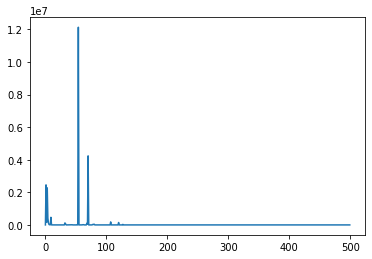

In [0]:
train(classifier=Net().to(device),
      data=digit_dataset,
      criterion_type=nn.CrossEntropyLoss,
      optimizer_type=optim.Adam,
      BATCH_SIZE=4,
      LEARNING_RATE=0.001,
      VERBOSE=True,
     )